In [3]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Optional: Display settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Step 2: Load orbital data
orbital_data = pd.read_csv("orbital_elements/CryoSat-2.csv")
orbital_data['timestamp'] = pd.to_datetime(orbital_data['Unnamed: 0'])
orbital_data.set_index('timestamp', inplace=True)
orbital_data.drop(columns='Unnamed: 0', inplace=True)

# Step 3: Load and preprocess manoeuvre data
with open("manoeuvres/cs2man.txt", "r") as file:
    lines = file.readlines()

pattern = re.compile(r"\d{4}\s+\d{3}\s+\d{2}\s+\d{2}")
timestamps = []
for line in lines:
    match = pattern.findall(line)
    if match:
        y, ddd, hh, mm = map(int, match[0].split())
        timestamps.append(datetime.strptime(f"{y} {ddd} {hh} {mm}", "%Y %j %H %M"))

man_df = pd.DataFrame({'manoeuvre_time': pd.to_datetime(timestamps)}).drop_duplicates().sort_values(by='manoeuvre_time')



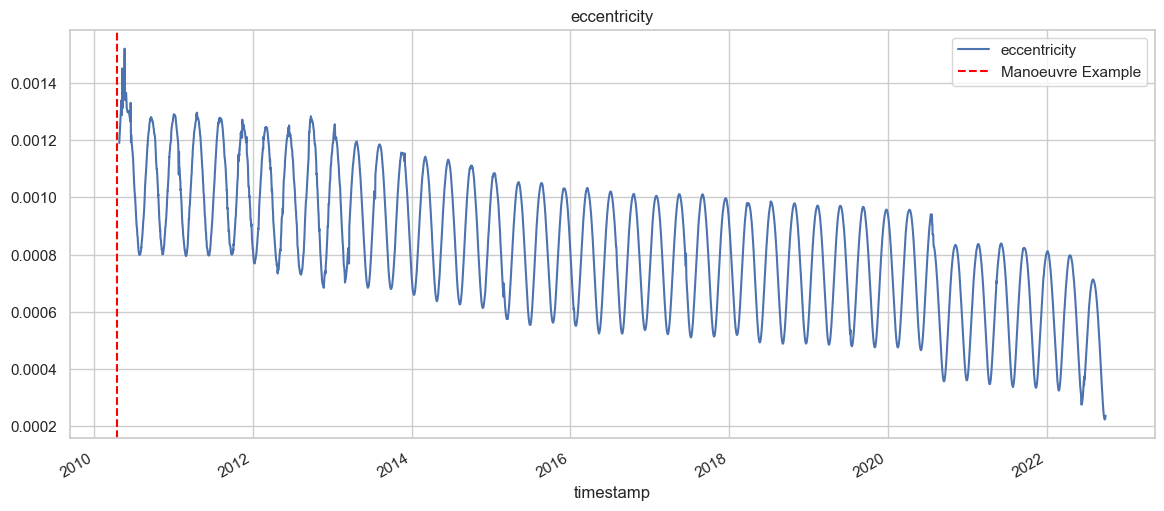

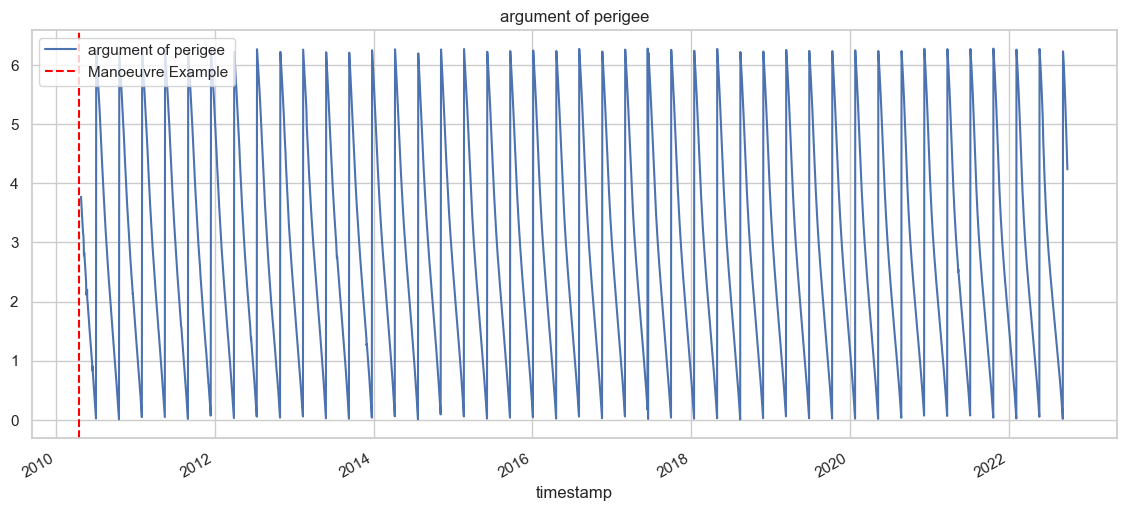

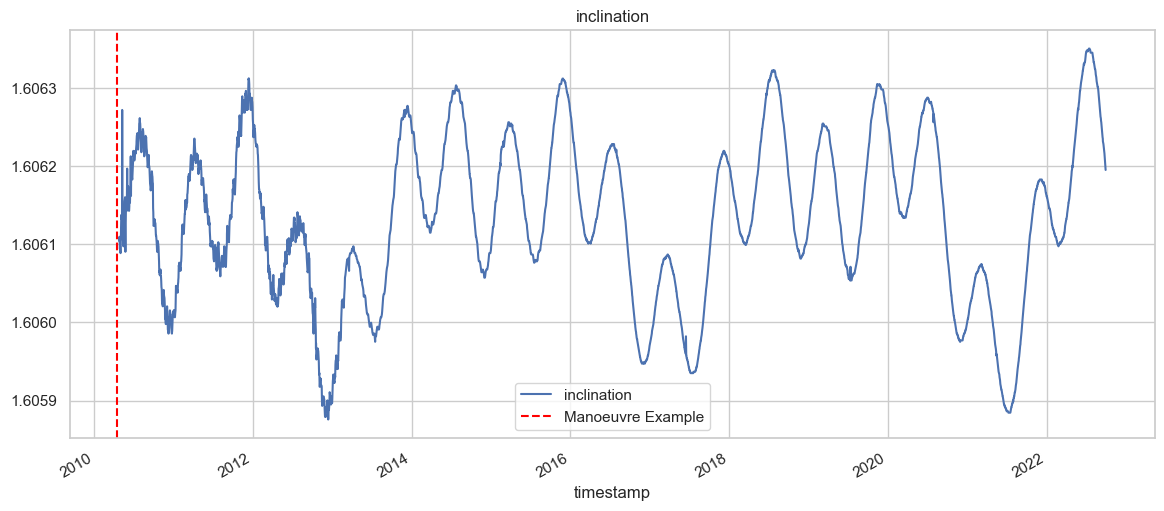

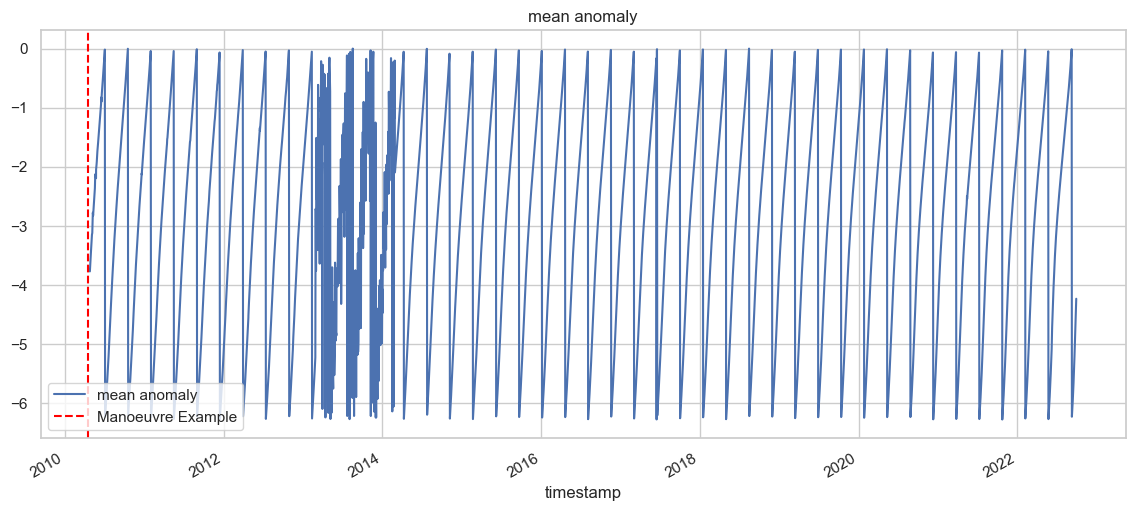

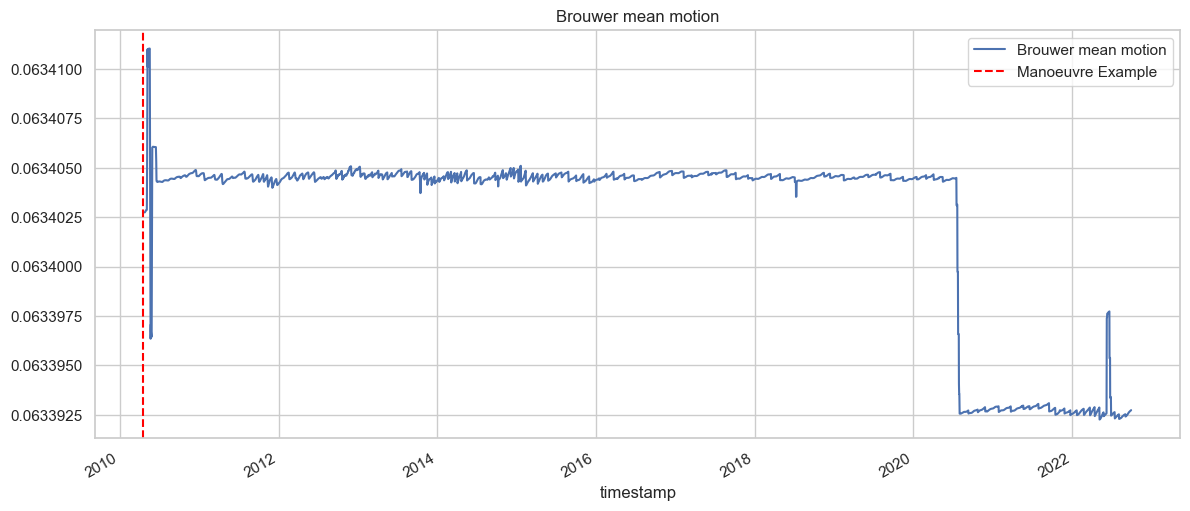

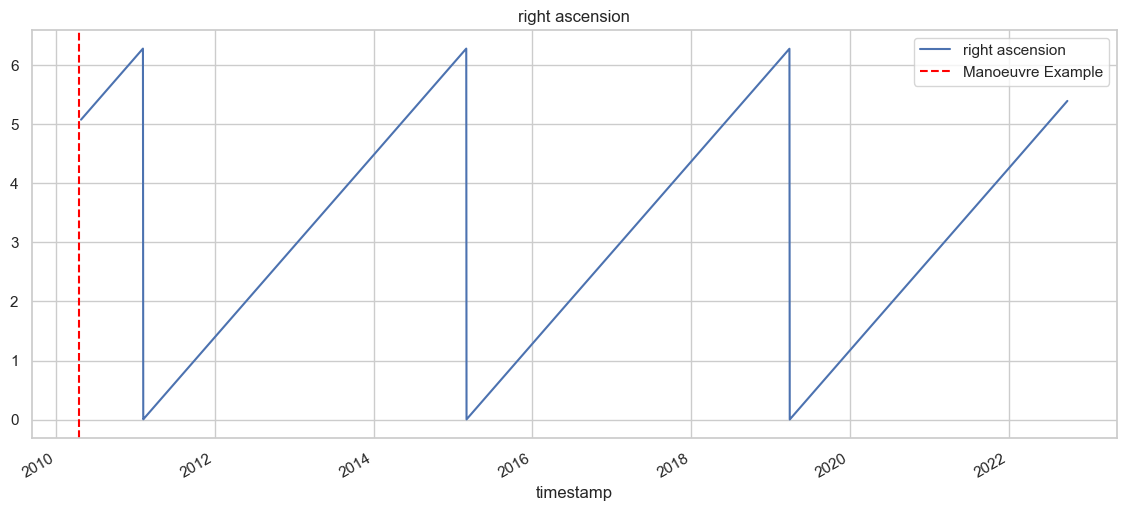

In [7]:
# Step 4: EDA - Plot time series
for col in orbital_data.columns:
    orbital_data[col].plot(title=col)
    plt.axvline(man_df['manoeuvre_time'].iloc[0], color='red', linestyle='--', label='Manoeuvre Example')
    plt.legend()
    plt.show()

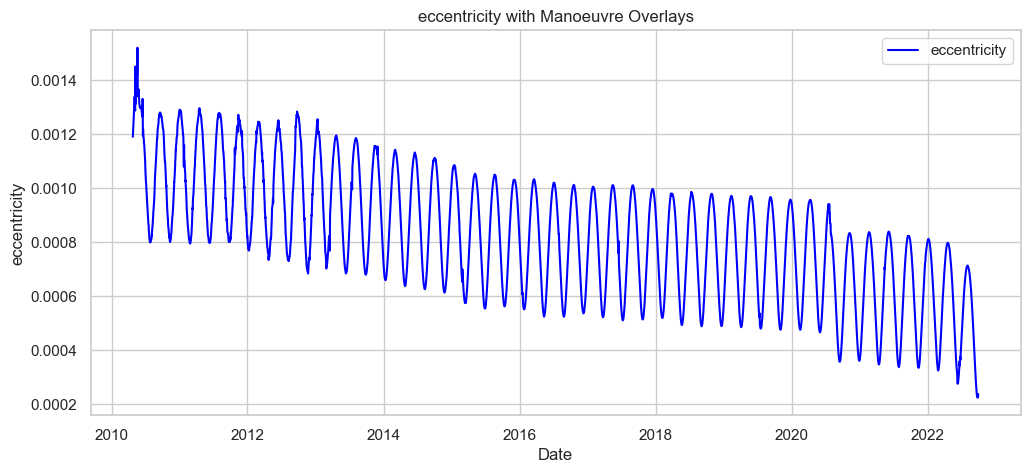

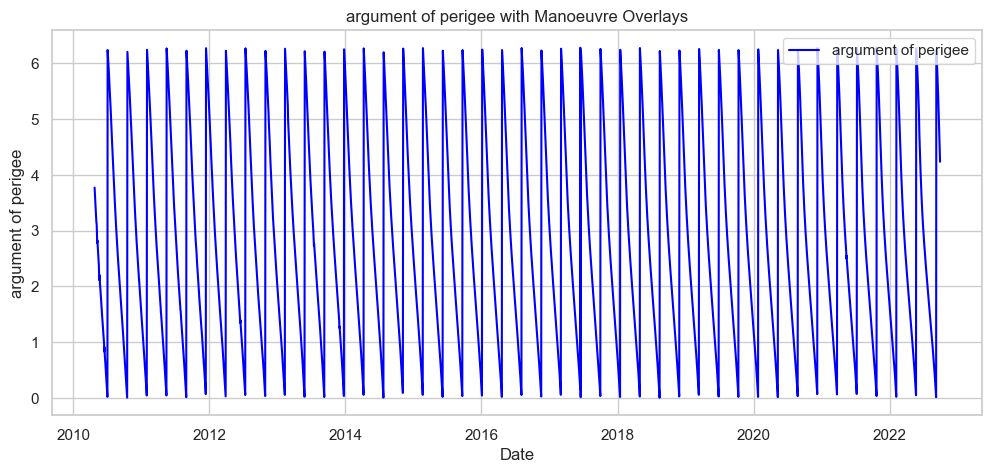

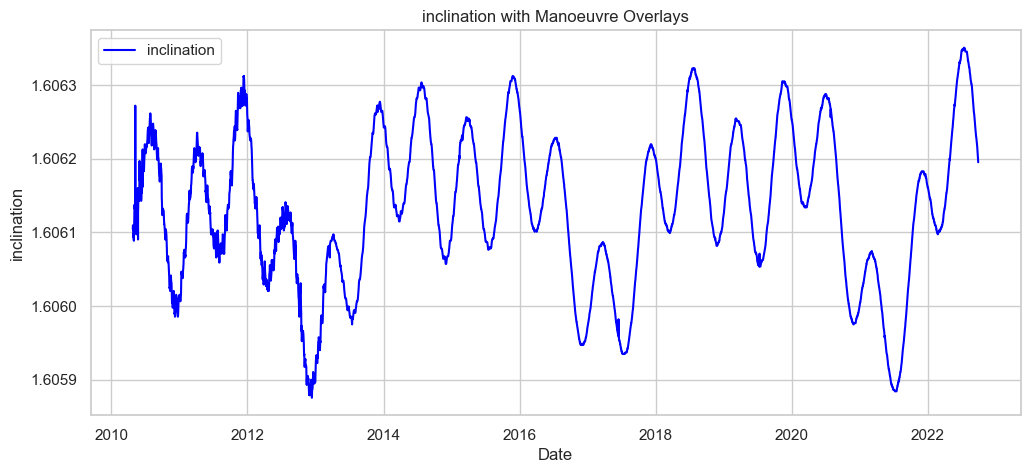

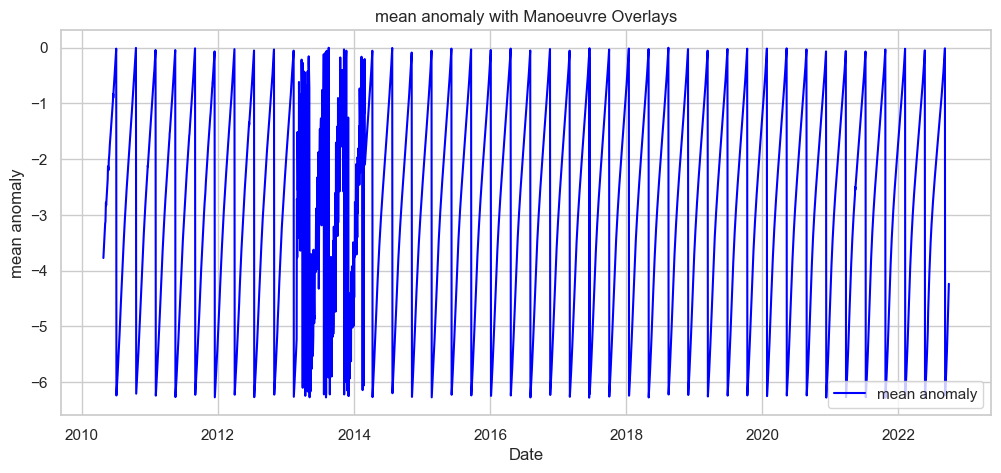

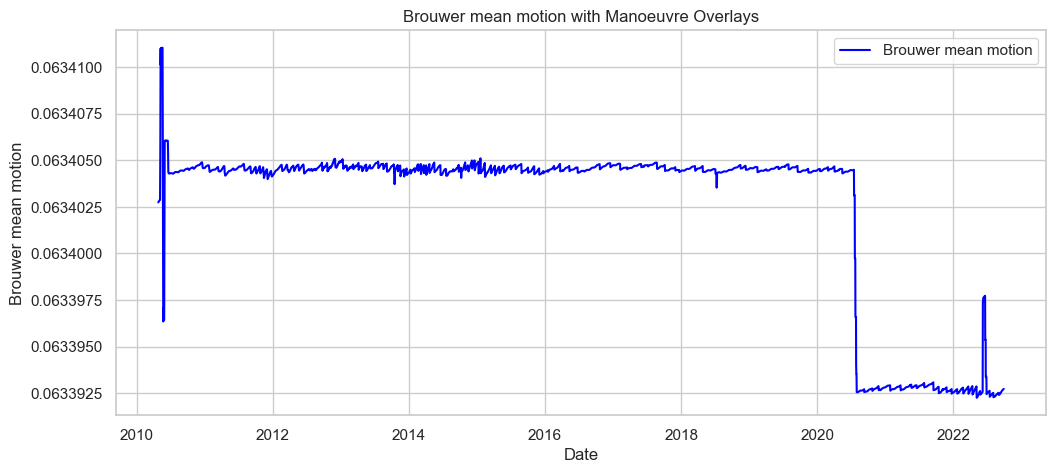

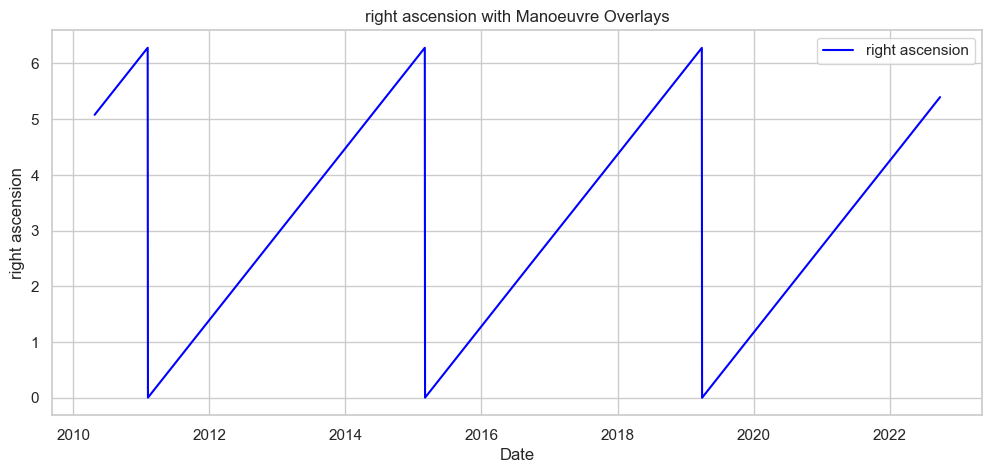

In [9]:
# 1. Overlay all manoeuvre timestamps
for col in orbital_data.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(orbital_data[col], label=col, color='blue')
    for m in man_df['manoeuvre_time']:
        if m in orbital_data.index:
            plt.axvline(m, color='red', linestyle='--', alpha=0.3)
    plt.title(f"{col} with Manoeuvre Overlays")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()


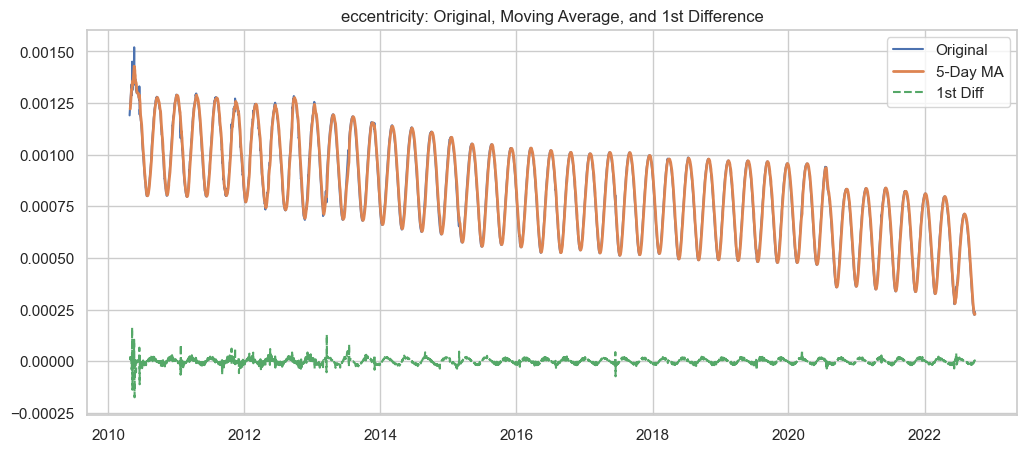

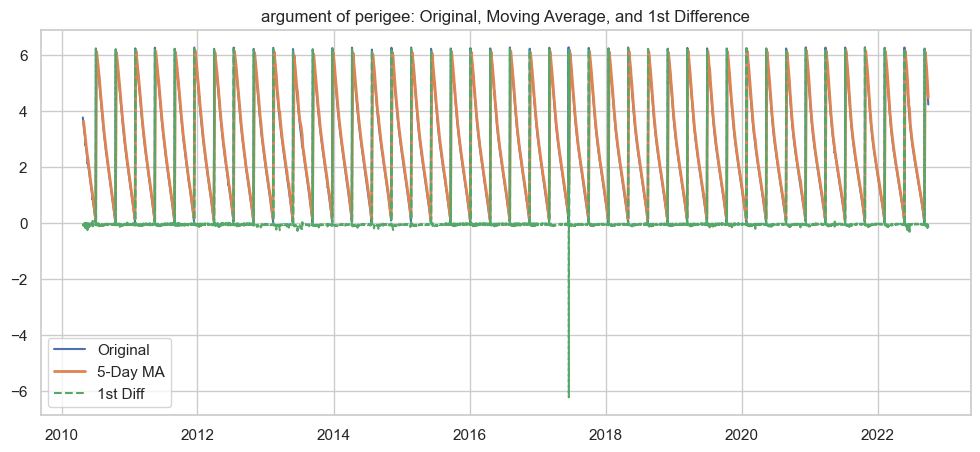

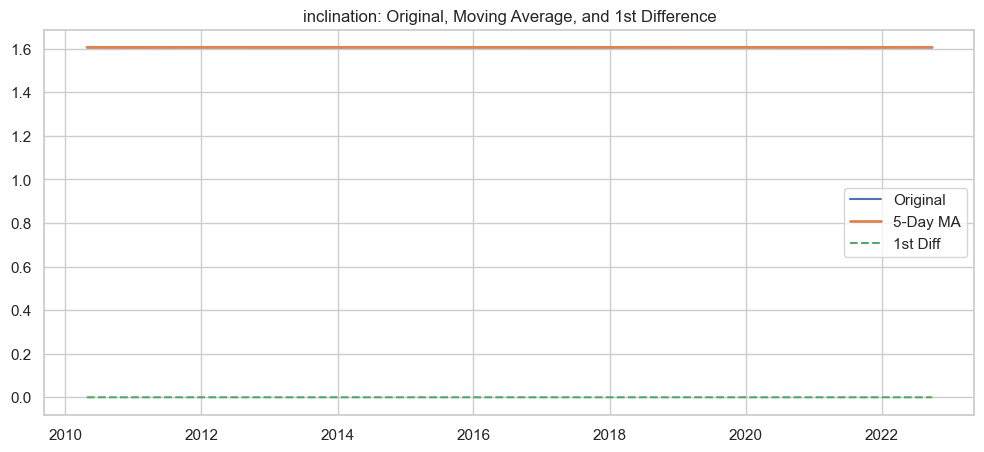

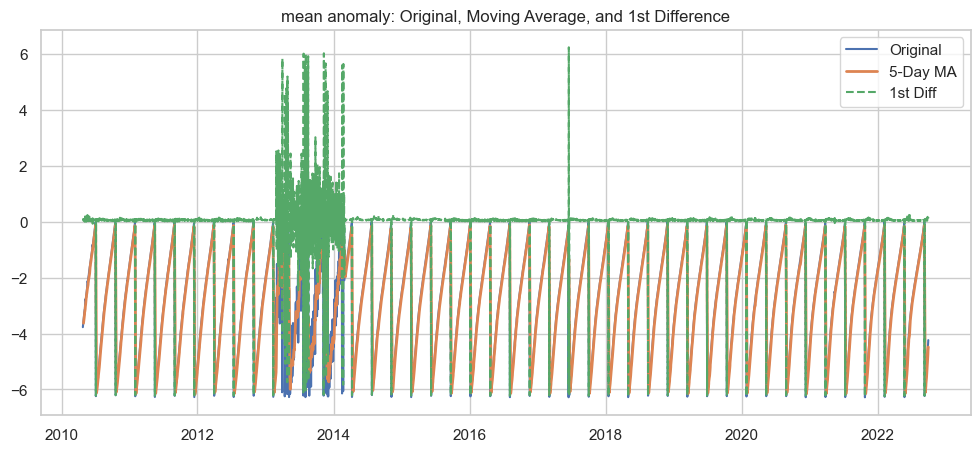

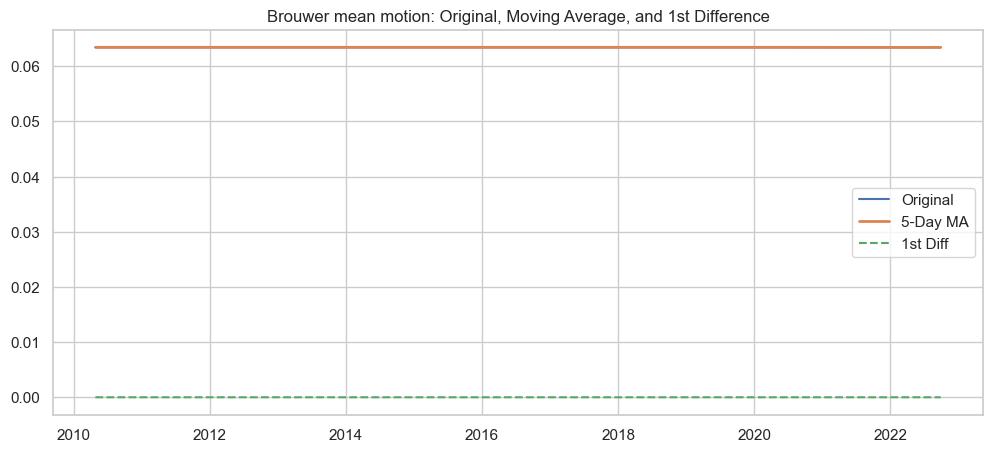

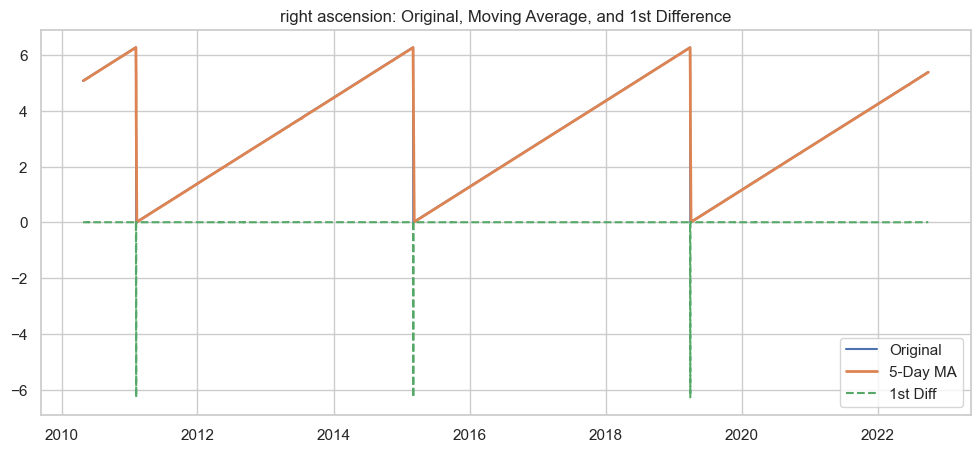

In [10]:
#  Moving average + first differences
window = 5  # days
for col in orbital_data.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(orbital_data[col], label='Original')
    plt.plot(orbital_data[col].rolling(window).mean(), label=f'{window}-Day MA', linewidth=2)
    plt.plot(orbital_data[col].diff(), label='1st Diff', linestyle='--')
    plt.title(f"{col}: Original, Moving Average, and 1st Difference")
    plt.legend()
    plt.grid(True)
    plt.show()

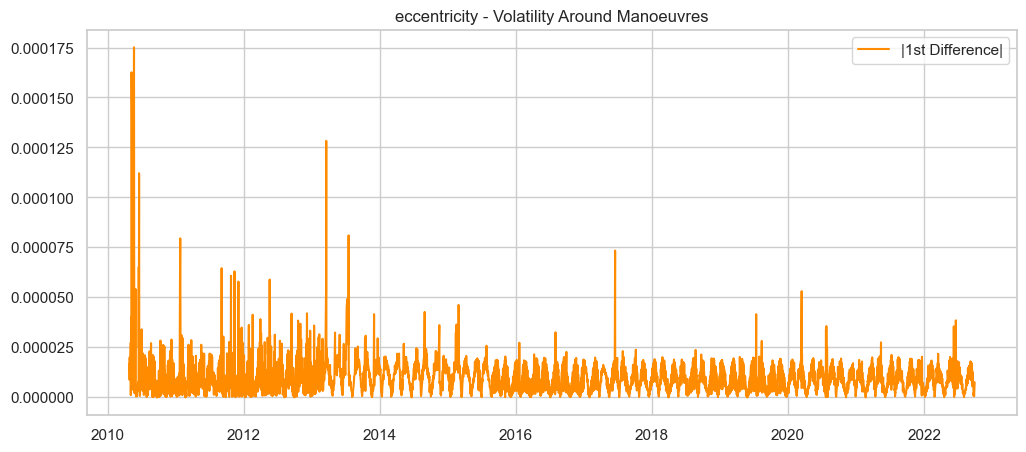

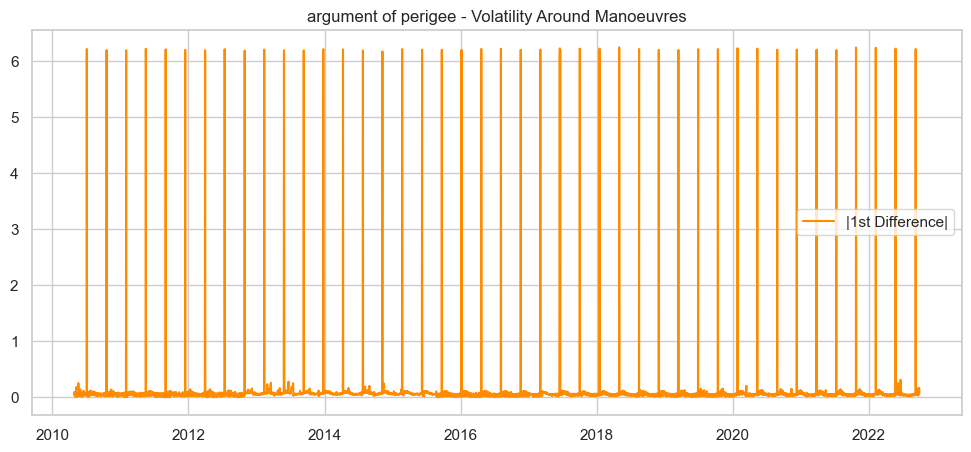

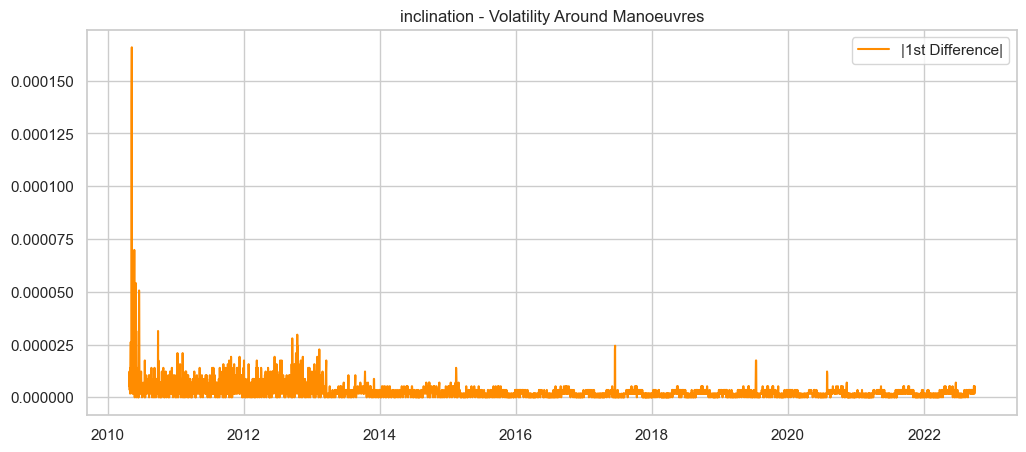

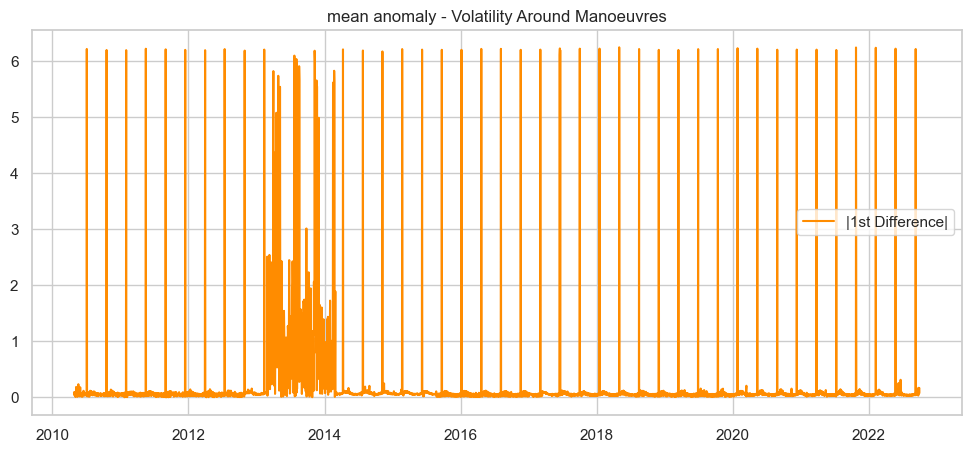

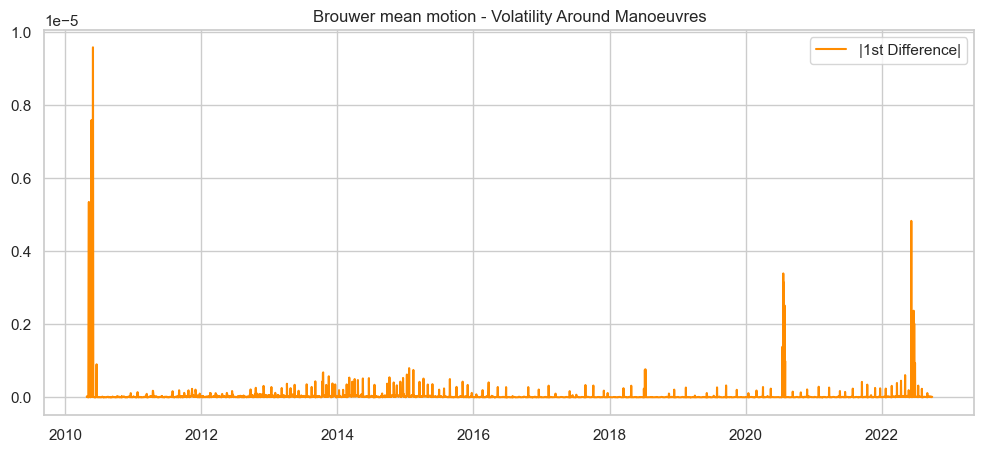

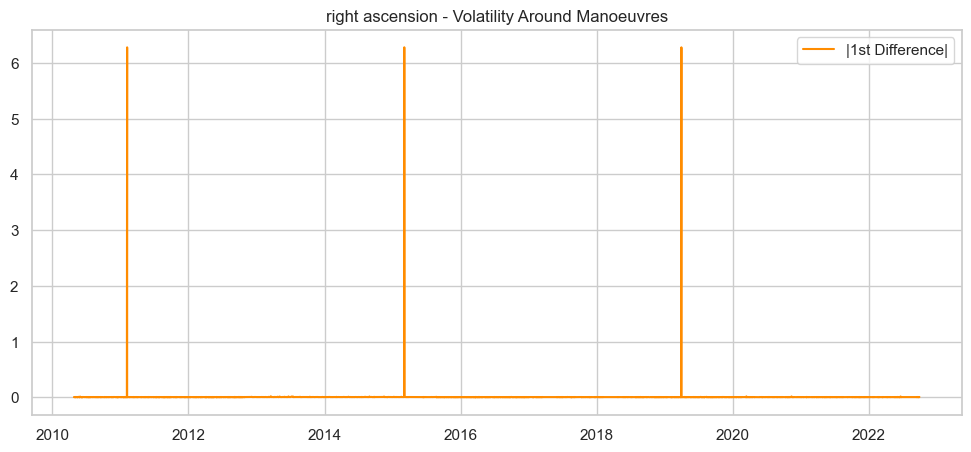

In [11]:
# 3. Volatility / Rate of Change (ROC)
for col in orbital_data.columns:
    roc = orbital_data[col].diff().abs()
    plt.figure(figsize=(12, 5))
    plt.plot(roc, label='|1st Difference|', color='darkorange')
    for m in man_df['manoeuvre_time']:
        if m in roc.index:
            plt.axvline(m, color='red', linestyle='--', alpha=0.3)
    plt.title(f"{col} - Volatility Around Manoeuvres")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
# 4. Quantitative scoring: Correlation between diff and manoeuvre events
# Create a binary manoeuvre label time series
orbital_data['manoeuvre'] = 0
orbital_data.loc[orbital_data.index.isin(man_df['manoeuvre_time']), 'manoeuvre'] = 1

for col in orbital_data.columns[:-1]:
    diff_series = orbital_data[col].diff()
    corr = diff_series.corr(orbital_data['manoeuvre'])
    print(f"Correlation of diff({col}) with manoeuvre flag: {corr:.4f}")


Correlation of diff(eccentricity) with manoeuvre flag: nan
Correlation of diff(argument of perigee) with manoeuvre flag: nan
Correlation of diff(inclination) with manoeuvre flag: nan
Correlation of diff(mean anomaly) with manoeuvre flag: nan
Correlation of diff(Brouwer mean motion) with manoeuvre flag: nan
Correlation of diff(right ascension) with manoeuvre flag: nan


In [ ]:
"""
ccentricity (4.png) & Inclination (5.png):

Both show 1st Differencing, indicating the original series likely had trends/non-stationarity.

After differencing, the values stabilize near zero with decreasing volatility. This suggests the transformed series may be stationary, making them candidates for ARIMA (with 
d
=
1
d=1).
Mean Anomaly (6.png):

The 1st Difference is applied here as well. The original data (0–6 scale) might have had a trend.

If differencing removes the trend and stabilizes variance, ARIMA could work. However, the sharp drop from 6 to 0 (pre-differencing) implies potential structural breaks or extreme volatility during maneuvers, which ARIMA might struggle to capture.

Right Ascension (7.png):

No explicit differencing is mentioned. The raw values (0–6) show a declining trend.

If the series is non-stationary (e.g., drifting mean), differencing (
d
=
1
d=1) would be required before applying ARIMA.

Key Considerations for ARIMA Suitability:

Stationarity: Elements requiring 1st differencing (eccentricity, inclination, mean anomaly) are closer to stationarity post-transformation. Right ascension needs testing (ADF/KPSS tests).

Volatility: Maneuvers introduce abrupt changes (spikes). ARIMA assumes smooth patterns, so frequent/unpredictable volatility may reduce accuracy unless modeled with additional components (e.g., SARIMA for seasonality, ARCH/GARCH for volatility clustering).

Data Frequency: If data points are annual (2010–2022), the limited observations (
n
=
13
n=13) may hinder robust ARIMA parameter estimation.

Conclusion:
Eccentricity and inclination are likely the best candidates for ARIMA (post-differencing). Mean anomaly and right ascension require further stationarity checks and may need hybrid models (e.g., ARIMA-GARCH) to account for maneuver-induced volatility. Always validate with statistical tests (e.g., ADF, PACF/ACF plots) before finalizing the model.

From the EDA plot of Brouwer mean motion – Volatility Around Manoeuvres, here's what we can interpret and conclude regarding its suitability for ARIMA forecasting:

✅ What We See in the Plot:
Sharp Spikes

Clear, isolated spikes in the 1st difference (volatility), especially:

Around 2010

Late 2019 to early 2020

2022

These spikes likely correlate with manoeuvres, indicating that the element responds sensitively to orbital changes.

Low Volatility in Between

Most of the time, the absolute 1st difference values are close to zero, suggesting that:

The series is relatively stable.

It does not vary much unless a manoeuvre occurs.

Stationarity & Predictability

Since values remain stable most of the time (small changes), the base series (not just the difference) is likely trend-stationary or can be made stationary with 1st differencing — suitable for ARIMA.

⚖️ Is This Feature Good for ARIMA Forecasting?
Yes — Brouwer mean motion looks like a strong candidate for ARIMA forecasting-based anomaly detection.

Here's why:

Aspect	Observed in Plot	Interpretation
Clear spikes at anomalies	✅ Yes	Good anomaly signal
Low noise in between	✅ Yes	Easier to model “normal” behavior
Stationary or difference-stationary	✅ Likely	Fits ARIMA assumption
Predictable trend	✅ Smooth overall motion	Makes ARIMA forecasting meaningful
🚀 Next Steps
You can now:

Use Brouwer mean motion as the main feature.

Build an ARIMA or ARIMA+model with residual-based anomaly detection.

Check residual spikes at manoeuvre timestamps.

"""

In [15]:
# Step 5: Choose a feature (example: "Brouwer mean motion")
feature = "Brouwer mean motion"
ts = orbital_data[feature]


In [16]:
# Step 6: Stationarity test (ADF)
result = adfuller(ts.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -0.5522066820531957
p-value: 0.8814198718364359


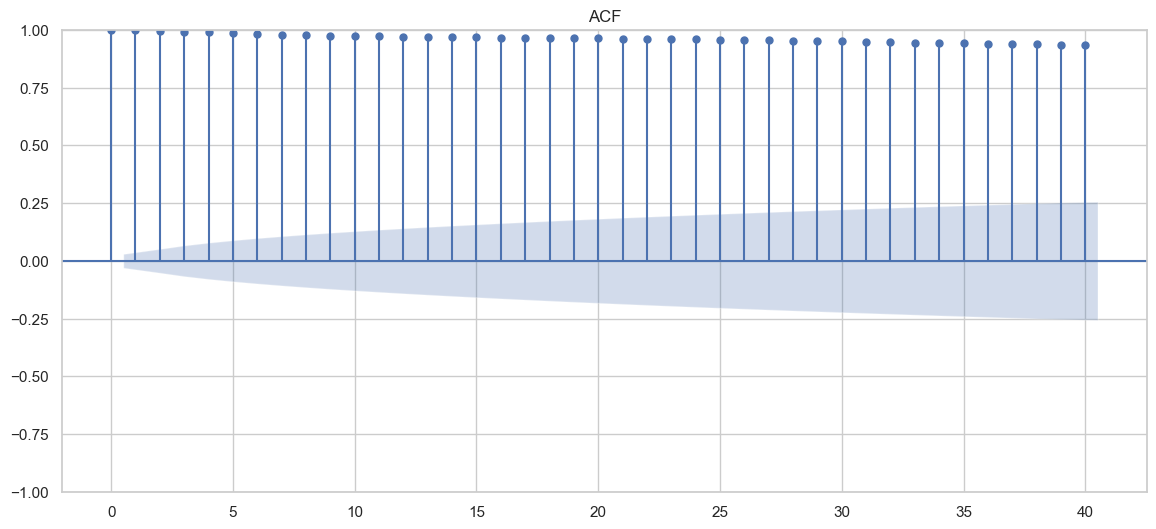

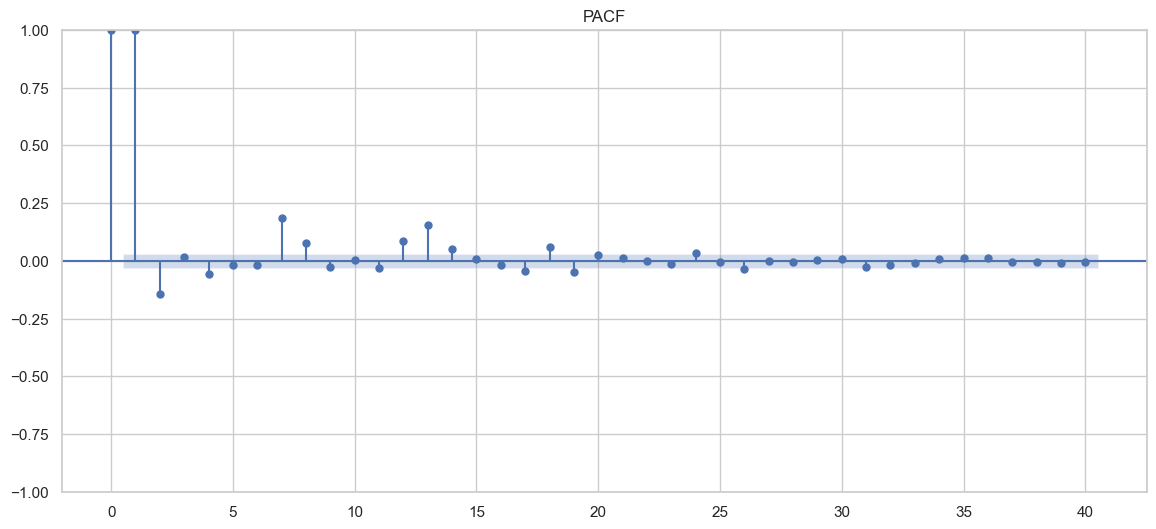

In [17]:

# Step 7: ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts.dropna(), lags=40)
plt.title("ACF")
plt.show()

plot_pacf(ts.dropna(), lags=40)
plt.title("PACF")
plt.show()


In [18]:

# Step 8: Differencing if needed
if result[1] > 0.05:
    ts_diff = ts.diff().dropna()
    print("Data differenced.")
else:
    ts_diff = ts


Data differenced.


In [20]:

# Step 6: Stationarity test (ADF)
result = adfuller(ts_diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -22.080489875575573
p-value: 0.0


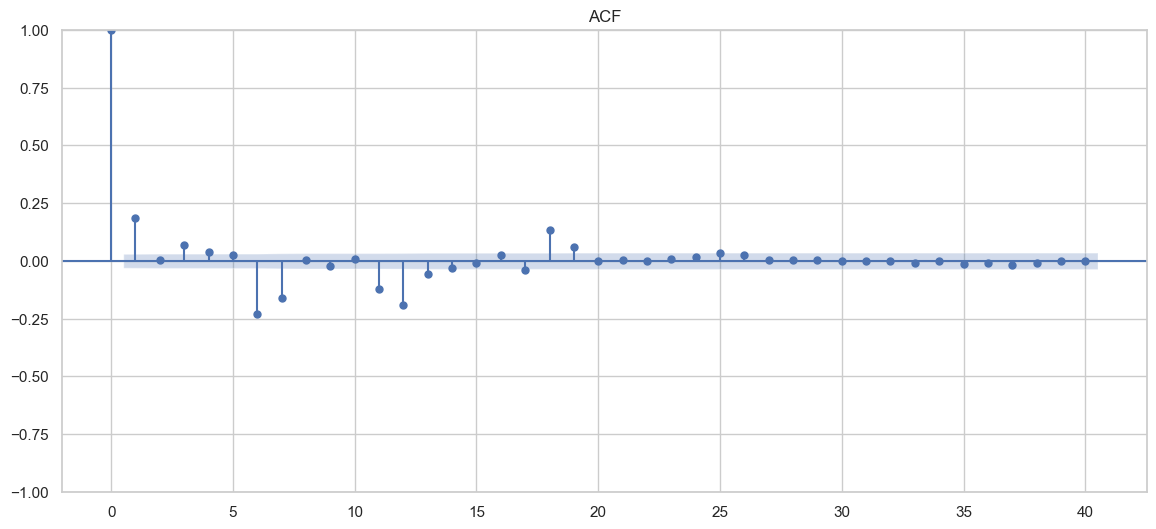

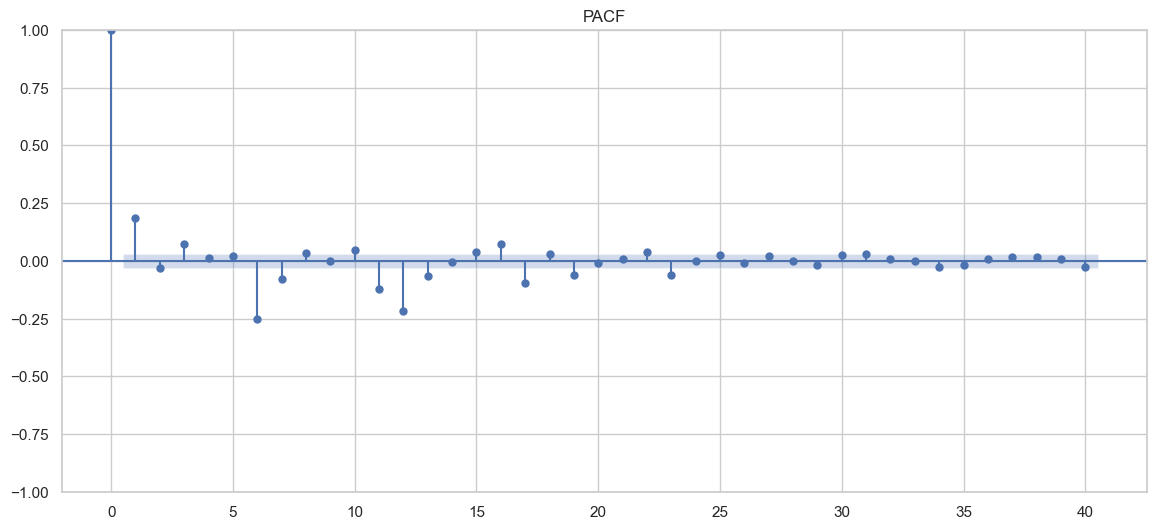

In [21]:

# Step 7: ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_diff.dropna(), lags=40)
plt.title("ACF")
plt.show()

plot_pacf(ts_diff.dropna(), lags=40)
plt.title("PACF")
plt.show()


In [22]:
# Step 9: Train/test split
train_size = int(len(ts_diff) * 0.8)
train, test = ts_diff.iloc[:train_size], ts_diff.iloc[train_size:]


In [23]:
# Step 10: Grid search for best ARIMA(p,d,q)
import warnings
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(train, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order: {best_order}, AIC: {best_aic}")



Best ARIMA order: (1, 1, 0), AIC: -88227.66486368181


In [24]:
# Step 11: Fit final model
model = ARIMA(train, order=best_order)
model_fit = model.fit()



In [25]:
# Step 12: Forecast
forecast = model_fit.forecast(steps=len(test))
residuals = test - forecast


In [27]:
# Step 13: Detect anomalies using threshold
threshold = 3 * np.std(residuals)
anomalies = residuals[np.abs(residuals) > threshold]
inferred_manoeuvre_times = anomalies.index


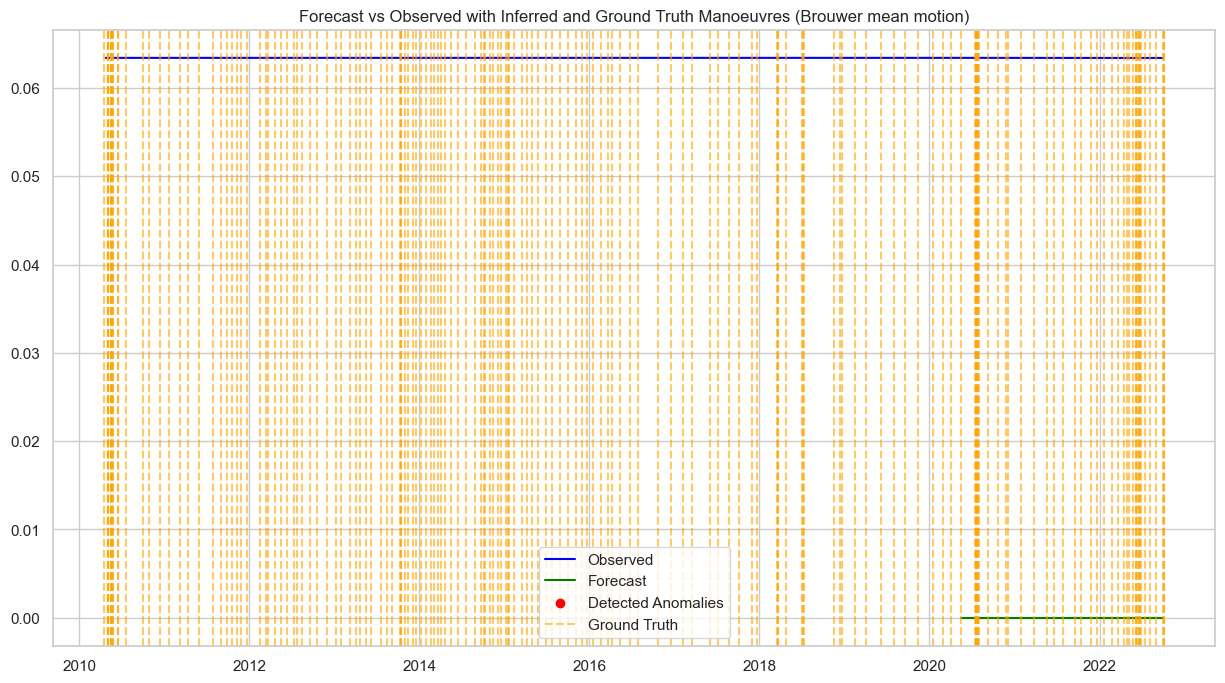

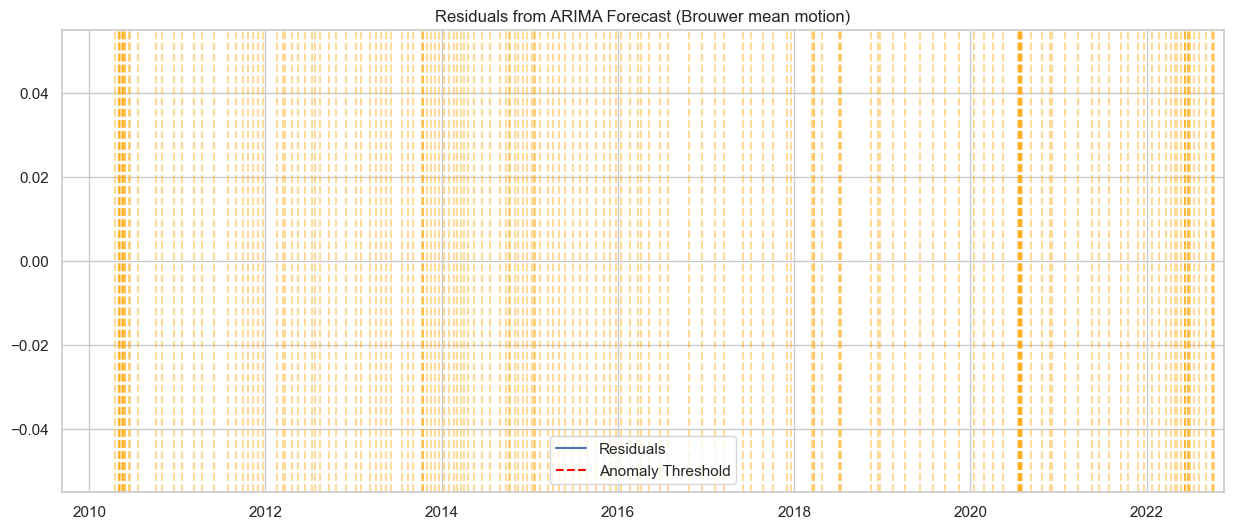

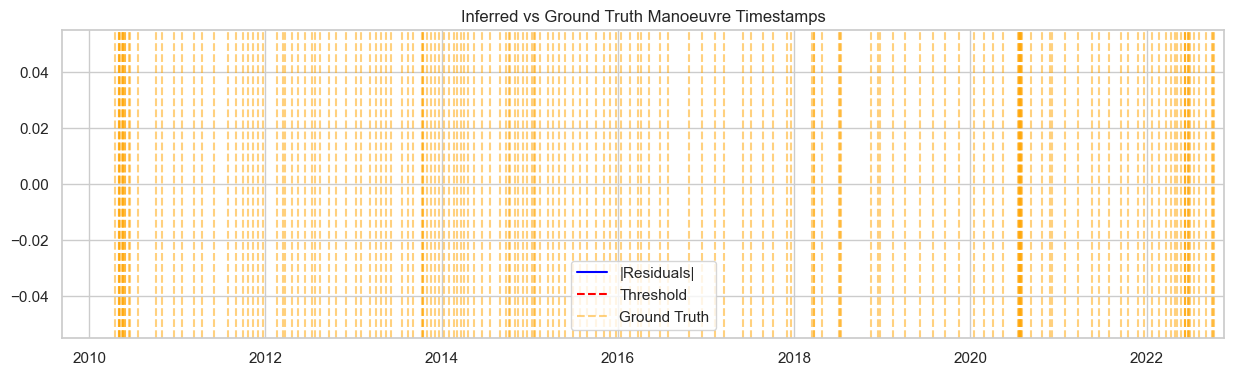

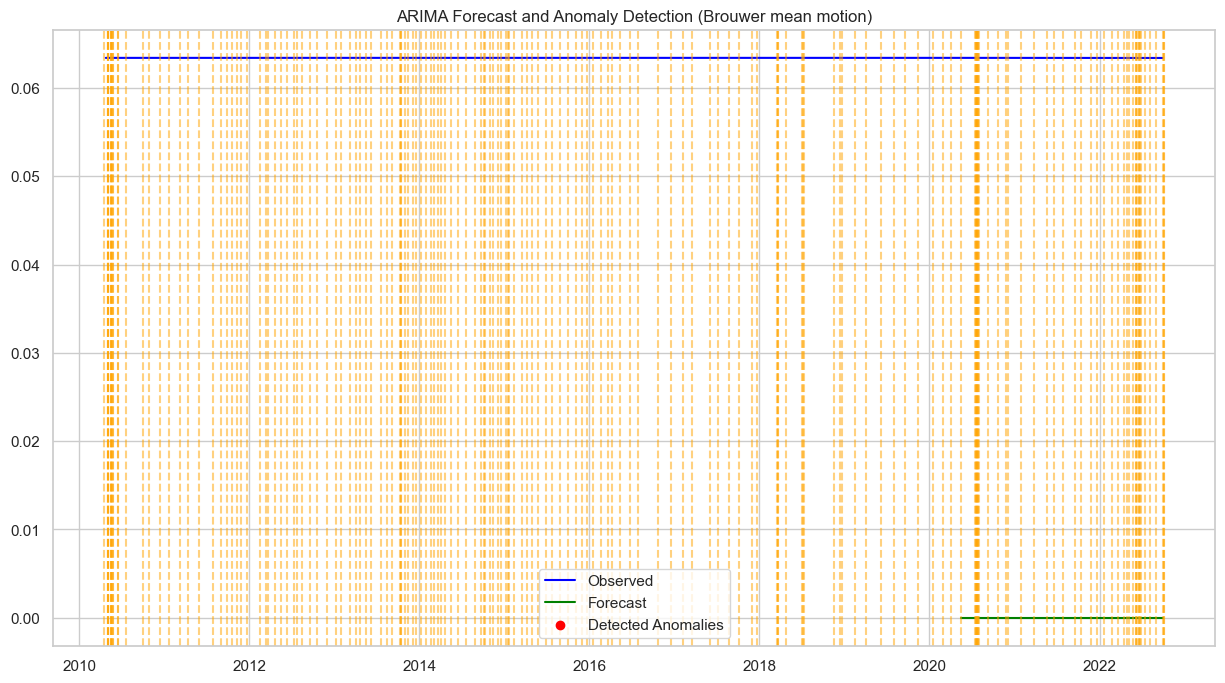

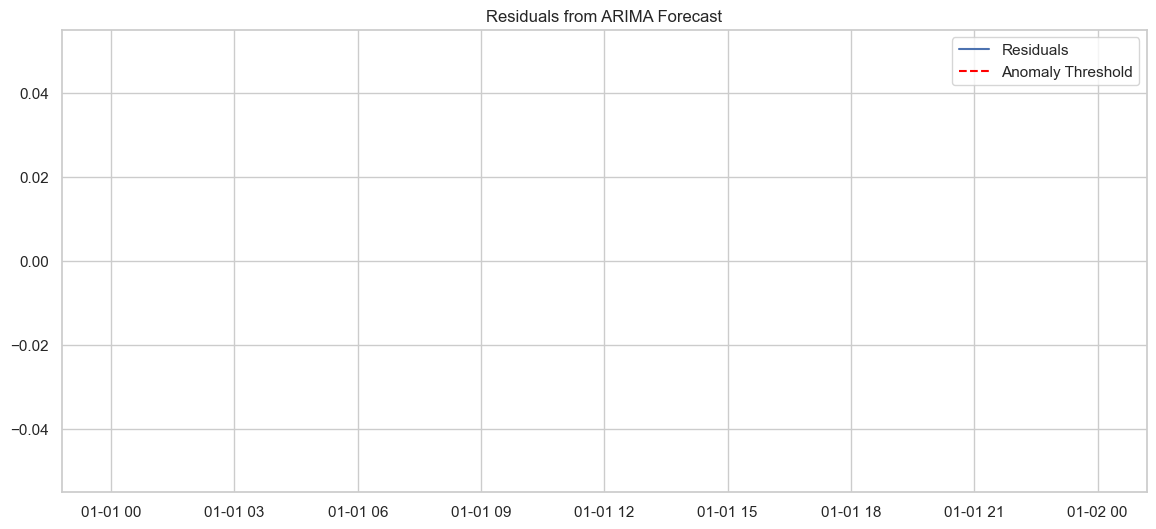

In [28]:

# Step 14: Plot forecast vs observed
plt.figure(figsize=(15, 8))
plt.plot(ts, label='Observed', color='blue')
plt.plot(test.index, forecast.cumsum() + train.iloc[-1], label='Forecast', color='green')
plt.scatter(anomalies.index, ts.loc[anomalies.index], color='red', label='Detected Anomalies')
for m in man_df['manoeuvre_time']:
    plt.axvline(m, color='orange', linestyle='--', alpha=0.6, label='Ground Truth' if m == man_df['manoeuvre_time'].iloc[0] else "")
plt.title(f"Forecast vs Observed with Inferred and Ground Truth Manoeuvres ({feature})")
plt.legend()
plt.show()


# Step 15: Plot residuals with threshold lines
plt.figure(figsize=(15, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.axhline(-threshold, color='red', linestyle='--')
for m in man_df['manoeuvre_time']:
    plt.axvline(m, color='orange', linestyle='--', alpha=0.4)
plt.title(f"Residuals from ARIMA Forecast ({feature})")
plt.legend()
plt.show()

# Step 16: Plot inferred manoeuvre timestamps vs ground truth
plt.figure(figsize=(15, 4))
plt.plot(np.abs(residuals), label='|Residuals|', color='blue')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
for t in inferred_manoeuvre_times:
    plt.axvline(t, color='green', linestyle='--', alpha=0.5, label='Inferred Manoeuvre' if t == inferred_manoeuvre_times[0] else "")
for m in man_df['manoeuvre_time']:
    plt.axvline(m, color='orange', linestyle='--', alpha=0.5, label='Ground Truth' if m == man_df['manoeuvre_time'].iloc[0] else "")
plt.title("Inferred vs Ground Truth Manoeuvre Timestamps")
plt.legend()
plt.show()

# Step 14: Plot all together
plt.figure(figsize=(15, 8))
plt.plot(ts, label='Observed', color='blue')
plt.plot(test.index, forecast.cumsum() + train.iloc[-1], label='Forecast', color='green')
plt.scatter(anomalies.index, ts.loc[anomalies.index], color='red', label='Detected Anomalies')
for m in man_df['manoeuvre_time']:
    plt.axvline(m, color='orange', linestyle='--', alpha=0.5)
plt.title(f"ARIMA Forecast and Anomaly Detection ({feature})")
plt.legend()
plt.show()

# Step 15: Plot residuals
plt.figure()
plt.plot(residuals, label="Residuals")
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.axhline(-threshold, color='red', linestyle='--')
plt.title("Residuals from ARIMA Forecast")
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (275,) and (276,)

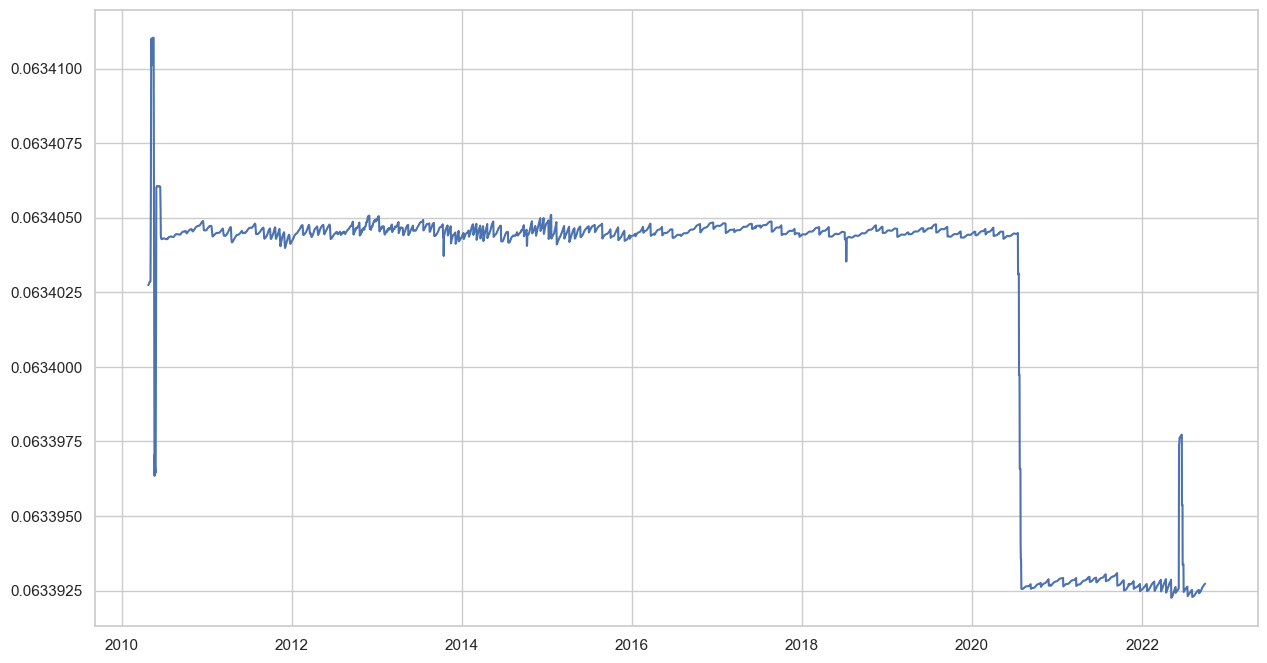

In [30]:
# Step 14: Enhanced combined plot with dual y-axis
plt.figure(figsize=(15, 8))

# Plot observed and predicted values
plt.plot(ts.index, ts, 'b-', label='Observed')
plt.plot(test.index, forecast.cumsum() + train.iloc[-1], 'r-', label='Predicted')

# Residuals on secondary y-axis
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(residuals.index, residuals, 'g-', label='Residuals')
ax2.axhline(0, color='black', linestyle='dotted', alpha=0.5)

# Plot detected anomalies
plt.scatter(anomalies.index, ts.loc[anomalies.index], color='red', s=50, label='Detected Anomalies')

# Ground truth manoeuvres
first_m = True
for m in man_df['manoeuvre_time']:
    if m in ts.index:
        plt.axvline(x=m, color='green', linestyle='--', alpha=0.7, label='Ground Truth' if first_m else "")
        first_m = False

# Axis labels
ax1.set_ylabel('Brouwer Mean Motion')
ax2.set_ylabel('Residuals')

# Title and legend
plt.title(f"Observed vs Predicted with Residuals and Anomaly Detection ({feature})")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Grid and formatting
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [31]:
# Align predicted values to test index
predicted = forecast.cumsum() + train.iloc[-1]
predicted.index = test.index

# Reconstruct full observed time series for residuals calculation
full_observed = pd.concat([train, test])
full_predicted = pd.concat([train, predicted])

# Calculate residuals
residuals = full_observed - full_predicted
residuals = residuals.dropna()

# Redefine anomalies based on residuals
threshold = 3 * np.std(residuals)
anomalies = residuals[np.abs(residuals) > threshold]

# === Dual Axis Plot ===
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot observed and predicted series
ax1.plot(ts.index, ts, 'b-', label='Observed')
ax1.plot(predicted.index, predicted, 'r-', label='Forecasted')
ax1.set_ylabel(f'{feature}', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot detected anomalies
ax1.scatter(anomalies.index, ts.loc[anomalies.index], color='red', s=50, label='Detected Anomalies')

# Mark ground truth manoeuvres
for i, m in enumerate(man_df['manoeuvre_time']):
    ax1.axvline(m, color='green', linestyle='--', alpha=0.8, label='Ground Truth' if i == 0 else "")

# Secondary y-axis for residuals
ax2 = ax1.twinx()
ax2.plot(residuals.index, residuals, color='gray', alpha=0.6, label='Residuals')
ax2.axhline(0, color='black', linestyle='dotted', alpha=0.5)
ax2.set_ylabel('Residuals', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Titles and Legends
fig.suptitle(f'Observed vs Forecasted with Residuals, Anomalies, and Ground Truth\n({feature})')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(alpha=0.3)
plt.show()


ValueError: Length mismatch: Expected axis has 276 elements, new values have 275 elements

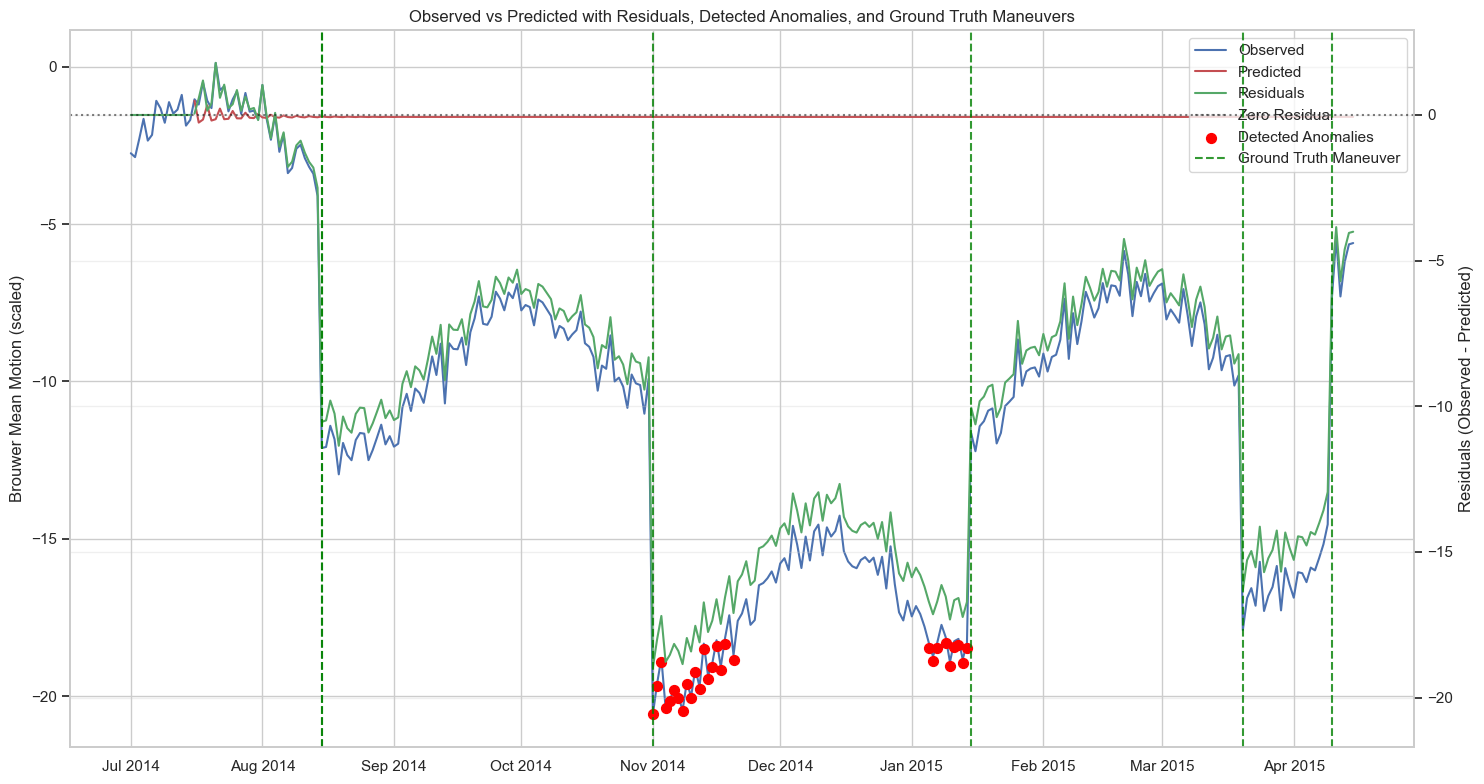

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


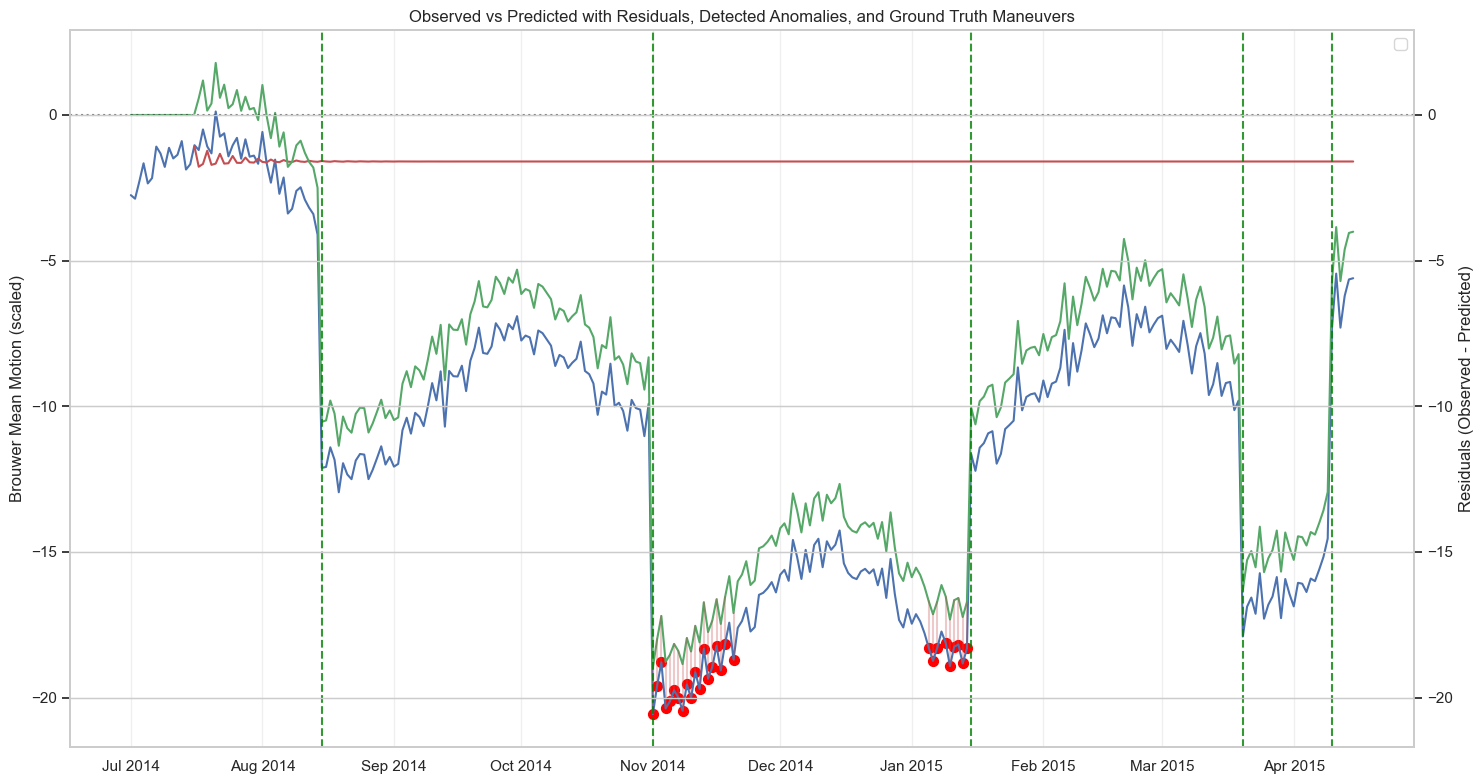

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import matplotlib.gridspec as gridspec

# Create sample data spanning Jul 2014 to Apr 2015
np.random.seed(42)
start_date = pd.to_datetime('2014-07-01')
end_date = pd.to_datetime('2015-04-15')
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate synthetic time series with some trends and seasonality
n = len(date_range)
trend = np.linspace(-3, 3, n)
seasonal = 2 * np.sin(np.linspace(0, 8 * np.pi, n))
noise = np.random.normal(0, 0.5, n)

# Base series
base_series = trend + seasonal + noise

# Add ground truth maneuvers with significant jumps
maneuver_dates = ['2014-08-15', '2014-11-01', '2015-01-15', '2015-03-20', '2015-04-10']
maneuver_indices = [date_range.get_loc(pd.to_datetime(date)) for date in maneuver_dates]

# Add the maneuvers to the series
ts_with_maneuvers = base_series.copy()
for idx in maneuver_indices:
    # Random large jump (positive or negative)
    jump = np.random.choice([-1, 1]) * np.random.uniform(5, 10)
    ts_with_maneuvers[idx:] += jump

# Create DataFrame
df = pd.DataFrame({'BrouwerMeanMotion': ts_with_maneuvers}, index=date_range)

# Create ground truth maneuvers dataframe
man_df = pd.DataFrame({'manoeuvre_time': pd.to_datetime(maneuver_dates)})

# Split into training and testing
train_end = pd.to_datetime('2014-07-15')
train = df.loc[:train_end]
test = df.loc[train_end:]

# Fit ARIMA model
p, d, q = 3, 1, 2  # Example ARIMA parameters
model = ARIMA(train['BrouwerMeanMotion'], order=(p, d, q))
model_fit = model.fit()

# Generate predictions for the test period
forecast = model_fit.forecast(steps=len(test))
predicted = pd.Series(forecast, index=test.index)

# Calculate residuals
residuals = df['BrouwerMeanMotion'] - pd.concat([train['BrouwerMeanMotion'], predicted])

# Define threshold for anomaly detection (e.g., 3 standard deviations)
threshold = 3 * np.std(residuals.dropna())

# Detect anomalies
anomalies = residuals[abs(residuals) > threshold]

# Create a combined plot with dual y-axis
plt.figure(figsize=(15, 8))

# Plot observed and predicted values
plt.plot(df.index, df['BrouwerMeanMotion'], 'b-', label='Observed')
plt.plot(test.index, predicted, 'r-', label='Predicted')

# Plot residuals on the same graph
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(residuals.index, residuals, 'g-', label='Residuals')
ax2.axhline(0, color='black', linestyle='dotted', alpha=0.5, label='Zero Residual')

# Mark detected anomalies
plt.scatter(anomalies.index, df.loc[anomalies.index, 'BrouwerMeanMotion'], 
            color='red', s=50, label='Detected Anomalies')

# Plot ground truth maneuvers
for m in man_df['manoeuvre_time']:
    plt.axvline(x=m, color='green', linestyle='--', alpha=0.8)

# Find the first maneuver to add to legend only once
first_maneuver = man_df['manoeuvre_time'].iloc[0]
plt.axvline(x=first_maneuver, color='green', linestyle='--', alpha=0.8, label='Ground Truth Maneuver')

# Configure axes
ax1.set_ylabel('Brouwer Mean Motion (scaled)')
ax2.set_ylabel('Residuals (Observed - Predicted)')
plt.title('Observed vs Predicted with Residuals, Detected Anomalies, and Ground Truth Maneuvers')
plt.grid(True, alpha=0.3)

# Format x-axis to show months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=0)
plt.xlabel('Time')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Alternative method using subplots to match the image more closely
fig = plt.figure(figsize=(15, 8))

# Create the plot
plt.plot(df.index, df['BrouwerMeanMotion'], 'b-', label='Observed')
plt.plot(test.index, predicted, 'r-', label='Predicted')
plt.plot(residuals.index, residuals, 'g-', label='Residuals')

# Add a dotted line at zero for residuals
plt.axhline(0, color='black', linestyle='dotted', alpha=0.5, label='Zero Residual')

# Mark detected anomalies with red dots
for idx in anomalies.index:
    plt.scatter(idx, df.loc[idx, 'BrouwerMeanMotion'], color='red', s=50)
    # Add connecting line to residual point
    plt.plot([idx, idx], [df.loc[idx, 'BrouwerMeanMotion'], residuals.loc[idx]], 'r-', alpha=0.3)

# Add one red dot to legend
plt.scatter([], [], color='red', s=50, label='Detected Anomalies')

# Add ground truth maneuvers as vertical dashed lines
for m in man_df['manoeuvre_time']:
    plt.axvline(x=m, color='green', linestyle='--', alpha=0.8)

# Add one maneuver line to legend
plt.plot([], [], color='green', linestyle='--', alpha=0.8, label='Ground Truth Maneuver')

# Configure axes
plt.ylabel('Brouwer Mean Motion (scaled)')
plt.title('Observed vs Predicted with Residuals, Detected Anomalies, and Ground Truth Maneuvers')
plt.grid(True, alpha=0.3)

# Add right y-axis label
ax = plt.gca()
ax_right = ax.twinx()
ax_right.set_ylabel('Residuals (Observed - Predicted)')
# Match y-axis scales between left and right
ylim = ax.get_ylim()
ax_right.set_ylim(ylim)

# Format x-axis to show months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=0)
plt.xlabel('Time')

# Add legend
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

ADF Statistic: -4.149340242468533
p-value: 0.0008018008251893836


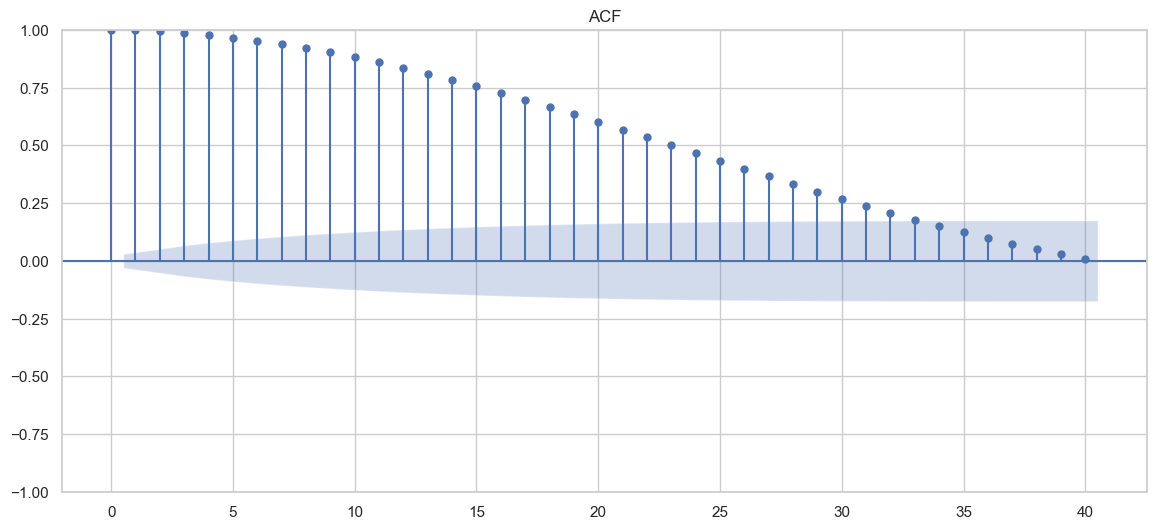

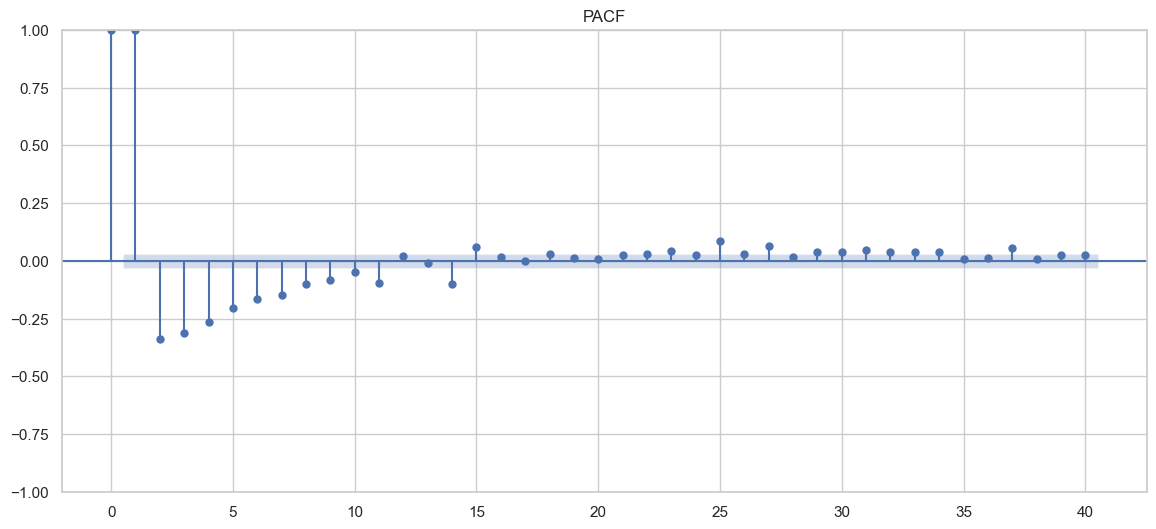

Best ARIMA order: (3, 0, 3), AIC: -87840.95314320765
Next predicted value (differenced): 0.00024323534022547525
Next predicted value: 0.00024323534022547525


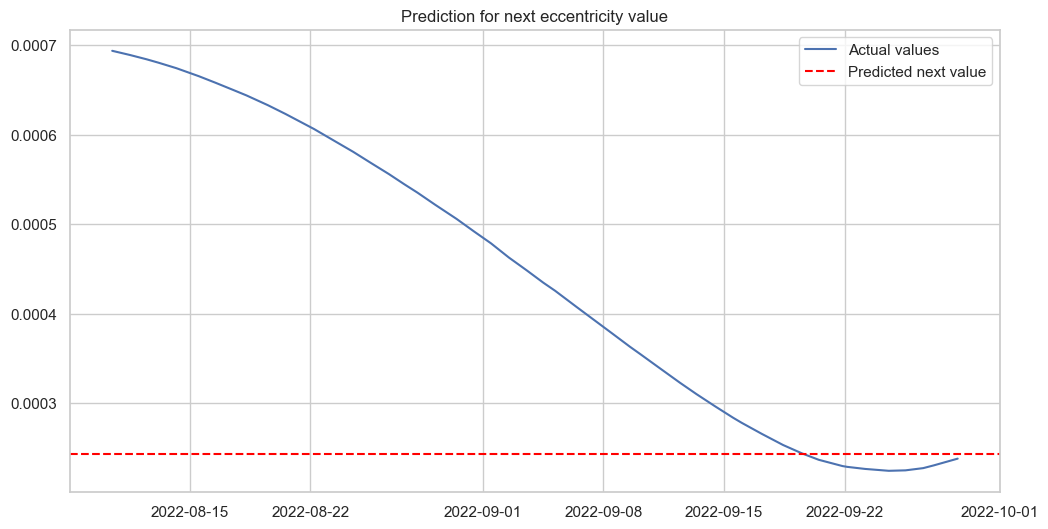

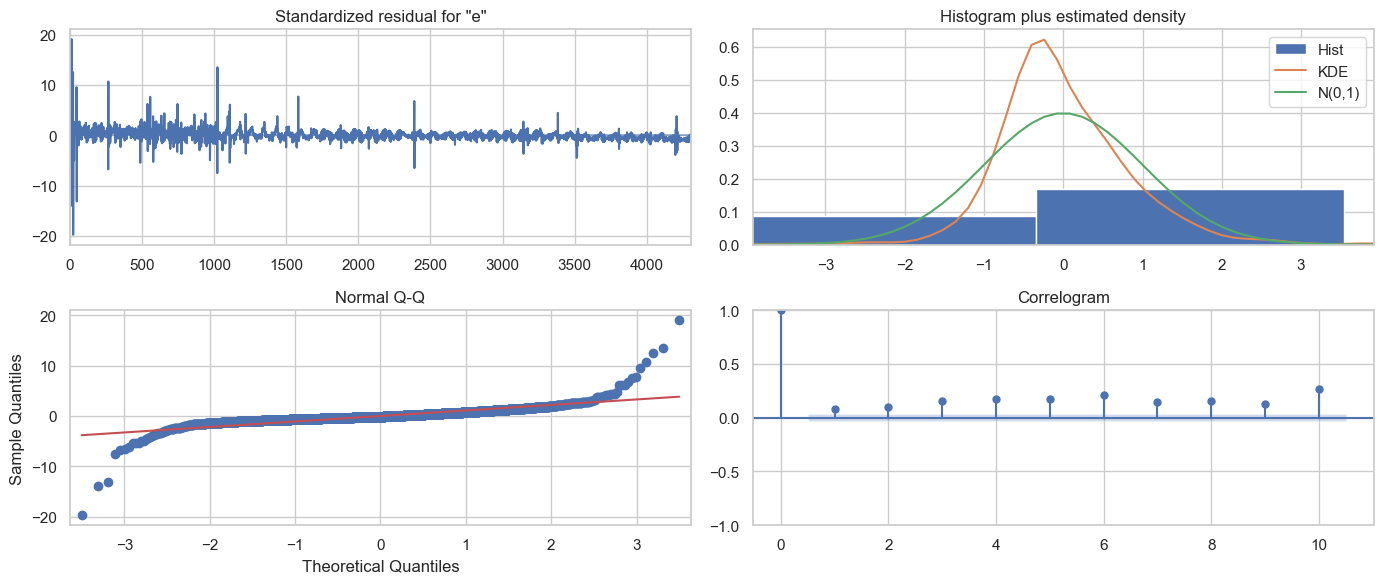

In [37]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Optional: Display settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Step 2: Load orbital data
orbital_data = pd.read_csv("orbital_elements/CryoSat-2.csv")
orbital_data['timestamp'] = pd.to_datetime(orbital_data['Unnamed: 0'])
orbital_data.set_index('timestamp', inplace=True)
orbital_data.drop(columns='Unnamed: 0', inplace=True)

# Step 3: Choose a feature (example: "Brouwer mean motion")
feature = "eccentricity"
ts = orbital_data[feature]

# Step 4: Stationarity test (ADF)
result = adfuller(ts.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Step 5: Differencing if needed
if result[1] > 0.05:
    ts_diff = ts.diff().dropna()
    print("Data differenced.")
else:
    ts_diff = ts

# Step 6: ACF and PACF analysis
plot_acf(ts_diff.dropna(), lags=40)
plt.title("ACF")
plt.show()

plot_pacf(ts_diff.dropna(), lags=40)
plt.title("PACF")
plt.show()

# Step 7: Grid search for best ARIMA(p,d,q)
import warnings
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None
for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(ts_diff, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order: {best_order}, AIC: {best_aic}")

# Step 8: Fit final model on all data
model = ARIMA(ts_diff, order=best_order)
model_fit = model.fit()

# Step 9: Forecast the next value
forecast = model_fit.forecast(steps=1)
print(f"Next predicted value (differenced): {forecast.values[0]}")

# If we differenced, we need to reverse the differencing to get the actual prediction
if result[1] > 0.05:
    last_value = ts.iloc[-1]
    predicted_value = last_value + forecast.values[0]
    print(f"Next predicted value (actual): {predicted_value}")
else:
    predicted_value = forecast.values[0]
    print(f"Next predicted value: {predicted_value}")

# Step 10: Visualize the last few points and prediction
plt.figure(figsize=(12, 6))
plt.plot(ts[-50:], label='Actual values')
plt.axhline(predicted_value, color='red', linestyle='--', label='Predicted next value')
plt.title(f"Prediction for next {feature} value")
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Model diagnostics
model_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

In [39]:

# Sample code to create a proper time series plot with prediction
plt.figure(figsize=(12,6))
plt.plot(historical_dates, historical_values, 'b-', label='Historical Data')
plt.plot(prediction_dates, predicted_values, 'ro--', label='Predictions')
plt.title('Eccentricity Prediction')
plt.xlabel('Date')
plt.ylabel('Eccentricity Value')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'historical_dates' is not defined

<Figure size 1200x600 with 0 Axes>